In [78]:
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
import numpy as np
from konlpy.tag import Okt
import konlpy
import re
import pprint
import os
import numpy as np
import pandas as pd
import pyLDAvis.sklearn 

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from tqdm import tqdm
import time
import pygad
import random 
import copy
from itertools import combinations
import itertools
from collections import Counter

## 특허데이터 불러오기

In [3]:
data = pd.read_csv('합.csv')

In [4]:
data

,대표도면,출원번호,발명의명칭,발명의명칭(영문),상태,IPC분류,출원인,대리인,발명자,출원일자,등록번호,등록일자,공개번호,공개일자
0,NaN,1020220046602,스트레스 지수 측정을 위한 헬스케어 장치(HEALTHCARE APPARATUS FO...,HEALTHCARE APPARATUS FOR MEASURING STRESS SCORE,등록,A61B 5/00|A61B 5/11|A61B 5/024|A61B 5/16|A61B ...,주식회사 엠마헬스케어,박정환,손량희,2022.04.15,1024358080000,2022.08.19,NaN,NaN
1,NaN,1020220046601,심박수 측정을 위한 헬스케어 장치(HEALTHCARE APPARATUS FOR ME...,HEALTHCARE APPARATUS FOR MEASURING HEART RATE,등록,A61B 5/00|A61B 5/11|A61B 5/024|A61B 5/08|G16H ...,주식회사 엠마헬스케어,박정환,손량희,2022.04.15,1024168780000,2022.06.30,NaN,NaN
2,NaN,1020210099585,이용자 맞춤형 스마트 헬스케어 시스템 및 방법(User-customized smar...,User-customized smart healthcare system and me...,등록,G16H 50/20|G16H 50/70|G16H 10/60|G06N 20/00,(주)듀얼헬스케어,특허법인오암,김영이,2021.07.29,1023839960000,2022.04.04,NaN,NaN
3,NaN,1020200072726,개인건강데이터와 의료데이터를 활용한 개인 맞춤형 헬스케어 시스템(Personal c...,Personal custom healthcare system that utilize...,등록,G16H 50/30|G16H 10/65|G16H 15/00|G16H 80/00,(주)듀얼헬스케어,특허법인오암,김영이,2020.06.16,1022004220000,2021.01.04,NaN,NaN
4,NaN,1020180138570,신호음을 기반으로 한 전용 콘텐츠 처방 및 헬스케어 관리 시스템(Dedicated ...,Dedicated content prescription and health care...,등록,G16H 50/30|G16H 80/00|A61B 5/02|A63B 24/00|G06...,김대정,김상욱,김대정,2018.11.12,1022441480000,2021.04.19,1.020200e+12,2020.05.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,NaN,1020207009306,무선 통신 시스템에서 보조 정보를 송신하는 장치 및 방법(APPARATUS AND ...,APPARATUS AND METHOD FOR TRANSMITTING ASSISTAN...,등록,H04W 72/04|H04W 24/10,삼성전자주식회사,윤앤리특허법인(유한),반 데르 벨데 힘케,2019.09.30,1022242770000,2021.03.02,1.020200e+12,2020.04.08
356,NaN,1020170074648,무선 셀룰라 통신 시스템에서 제어 및 데이터 정보 자원 매핑 방법 및 장치(CONT...,CONTROL AND DATA INFORMATION RESOURCE MAPPING ...,등록,H04W 72/04|H04W 72/12,삼성전자주식회사,윤앤리특허법인(유한),박성진|여정호|오진영|배태한|김윤선,2017.06.14,1023204390000,2021.10.27,1.020180e+12,2018.09.18
357,NaN,1020207014056,통합된 액세스 및 백홀의 전력 제어 개선 및 관련(IMPROVEMENTS IN AN...,IMPROVEMENTS IN AND RELATING TO POWER CONTROL ...,등록,H04W 52/36|H04W 52/54|H04W 74/00|H04W 74/08|H0...,삼성전자주식회사,윤앤리특허법인(유한),치 이난|최승훈|류현석,2019.09.27,1022143200000,2021.02.03,1.020200e+12,2020.05.27
358,NaN,1020197030309,업링크 전력 제어를 위한 방법 및 장치(METHOD AND DEVICE FOR UP...,METHOD AND DEVICE FOR UPLINK POWER CONTROL,등록,H04W 52/32|H04W 52/14|H04L 27/26,삼성전자주식회사,윤앤리특허법인(유한),푸 징씽|퀴안 첸|장 잉지에|유 빈|시옹치|선 페이페이,2018.04.17,1022109900000,2021.01.27,1.020190e+12,2019.11.04


In [5]:
df=data.drop(columns=['대표도면', '상태', 'IPC분류', '출원인', '대리인', '발명자', '공개번호', '공개일자'])
df=df.reset_index(drop=True)

## 발명의명칭 뽑아내 토큰화

In [6]:
df['발명의명칭'] = df['발명의명칭'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_15956/3746655113.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['발명의명칭'] = df['발명의명칭'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [7]:
df.head()

,출원번호,발명의명칭,발명의명칭(영문),출원일자,등록번호,등록일자
0,1020220046602,스트레스 지수 측정을 위한 헬스케어 장치,HEALTHCARE APPARATUS FOR MEASURING STRESS SCORE,2022.04.15,1024358080000,2022.08.19
1,1020220046601,심박수 측정을 위한 헬스케어 장치,HEALTHCARE APPARATUS FOR MEASURING HEART RATE,2022.04.15,1024168780000,2022.06.30
2,1020210099585,이용자 맞춤형 스마트 헬스케어 시스템 및 방법,User-customized smart healthcare system and me...,2021.07.29,1023839960000,2022.04.04
3,1020200072726,개인건강데이터와 의료데이터를 활용한 개인 맞춤형 헬스케어 시스템,Personal custom healthcare system that utilize...,2020.06.16,1022004220000,2021.01.04
4,1020180138570,신호음을 기반으로 한 전용 콘텐츠 처방 및 헬스케어 관리 시스템,Dedicated content prescription and health care...,2018.11.12,1022441480000,2021.04.19


In [8]:
stopwords = ['을','를','의','가','이','은','들','는','좀','잘','걍','과','도','으로','자','에','와','한','하다','헬', '스케', '어', '및']

In [9]:
# 형태소 분석기 OKT를 사용한 토큰화 작업 (다소 시간 소요)
okt = Okt()

tokenized_data = []
for sentence in tqdm(df['발명의명칭']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)

100%|████████████████████████████████████████████████████████████████████████████████| 360/360 [00:12<00:00, 28.77it/s]


In [10]:
tokenized_data

[['스트레스', '지수', '측정', '위', '장치'],
 ['심박수', '측정', '위', '장치'],
 ['이용자', '맞춤', '형', '스마트', '시스템', '방법'],
 ['개인', '건강', '데이터', '의료', '데이터', '활용', '개인', '맞춤', '형', '시스템'],
 ['신호', '음', '기반', '전용', '콘텐츠', '처방', '관리', '시스템'],
 ['기반', '실감', '체험', '형', '서비스', '시스템'],
 ['시니어', '건강', '위', '홈', '제공', '방법', '제공', '장치'],
 ['인공', '지능', '기반', '서비스', '제공', '장치'],
 ['위', '증강현실', '디스플레이', '장치', '이르다', '이용', '시스템'],
 ['웨어', '러블', '센서', '소셜', '네트워크', '데이터', '활용', '모니터링', '방법', '장치'],
 ['워치', '손목', '밴드', '플렉시블', '피씨', '비', '인서트', '사출', '성형', '장치'],
 ['운동량', '체크', '위', '스마트', '시스템'],
 ['웨어', '러블', '디바이스', '이용', '제공', '시스템'],
 ['시스템'],
 ['서비스', '제공', '방법', '서버', '컴퓨터', '프로그램'],
 ['스마트', '매트리스'],
 ['방',
  '사상체질',
  '현',
  '대',
  '의학',
  '융합',
  '되다',
  '건강',
  '정보',
  '기반',
  '개인',
  '맞춤',
  '형',
  '플랫폼'],
 ['관리', '시스템', '그', '구동', '방법'],
 ['관리', '장치', '방법'],
 ['맞춤', '형', '서비스', '제공', '방법', '사용', '되다', '관리', '서버'],
 ['클라우드', '기반', '인공', '지능', '활용', '가상현', '실용', '콘텐츠', '제공', '위', '시스템', '방법'],
 ['반려동물', '용', '하

In [80]:
total_data = []
for i in range(len(tokenized_data)):
    for j in range(len(tokenized_data[i])):
        total_data.append(tokenized_data[i][j])
total_data

['스트레스',
 '지수',
 '측정',
 '위',
 '장치',
 '심박수',
 '측정',
 '위',
 '장치',
 '이용자',
 '맞춤',
 '형',
 '스마트',
 '시스템',
 '방법',
 '개인',
 '건강',
 '데이터',
 '의료',
 '데이터',
 '활용',
 '개인',
 '맞춤',
 '형',
 '시스템',
 '신호',
 '음',
 '기반',
 '전용',
 '콘텐츠',
 '처방',
 '관리',
 '시스템',
 '기반',
 '실감',
 '체험',
 '형',
 '서비스',
 '시스템',
 '시니어',
 '건강',
 '위',
 '홈',
 '제공',
 '방법',
 '제공',
 '장치',
 '인공',
 '지능',
 '기반',
 '서비스',
 '제공',
 '장치',
 '위',
 '증강현실',
 '디스플레이',
 '장치',
 '이르다',
 '이용',
 '시스템',
 '웨어',
 '러블',
 '센서',
 '소셜',
 '네트워크',
 '데이터',
 '활용',
 '모니터링',
 '방법',
 '장치',
 '워치',
 '손목',
 '밴드',
 '플렉시블',
 '피씨',
 '비',
 '인서트',
 '사출',
 '성형',
 '장치',
 '운동량',
 '체크',
 '위',
 '스마트',
 '시스템',
 '웨어',
 '러블',
 '디바이스',
 '이용',
 '제공',
 '시스템',
 '시스템',
 '서비스',
 '제공',
 '방법',
 '서버',
 '컴퓨터',
 '프로그램',
 '스마트',
 '매트리스',
 '방',
 '사상체질',
 '현',
 '대',
 '의학',
 '융합',
 '되다',
 '건강',
 '정보',
 '기반',
 '개인',
 '맞춤',
 '형',
 '플랫폼',
 '관리',
 '시스템',
 '그',
 '구동',
 '방법',
 '관리',
 '장치',
 '방법',
 '맞춤',
 '형',
 '서비스',
 '제공',
 '방법',
 '사용',
 '되다',
 '관리',
 '서버',
 '클라우드',
 '기반',
 '인공',
 '지능',
 '활용',
 '가상현',
 '실용',

In [81]:
Counter(total_data)

Counter({'스트레스': 1,
         '지수': 1,
         '측정': 11,
         '위': 61,
         '장치': 177,
         '심박수': 2,
         '이용자': 1,
         '맞춤': 18,
         '형': 25,
         '스마트': 40,
         '시스템': 206,
         '방법': 235,
         '개인': 7,
         '건강': 13,
         '데이터': 28,
         '의료': 2,
         '활용': 9,
         '신호': 11,
         '음': 1,
         '기반': 43,
         '전용': 2,
         '콘텐츠': 5,
         '처방': 2,
         '관리': 21,
         '실감': 1,
         '체험': 1,
         '서비스': 39,
         '시니어': 6,
         '홈': 4,
         '제공': 46,
         '인공': 7,
         '지능': 8,
         '증강현실': 1,
         '디스플레이': 1,
         '이르다': 19,
         '이용': 53,
         '웨어': 6,
         '러블': 6,
         '센서': 6,
         '소셜': 1,
         '네트워크': 26,
         '모니터링': 15,
         '워치': 1,
         '손목': 1,
         '밴드': 5,
         '플렉시블': 1,
         '피씨': 1,
         '비': 16,
         '인서트': 1,
         '사출': 1,
         '성형': 1,
         '운동량': 1,
         '체크': 2,
    

## 기업의 기술 역량 키워드 설정
인공, 지능, 데이터, 기기, 디바이스, 스마트, 플랫폼

## 워드임베딩 작업(Word2vec)

In [11]:
from gensim.models import Word2Vec

C:\Users\sangmin\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [14]:
model = Word2Vec(sentences = tokenized_data, vector_size = 20, window = 3, min_count = 5, workers = 4, sg = 0)

In [15]:
model.wv.vectors.shape

(107, 20)

In [24]:
matrix = pd.DataFrame(model.wv.vectors)
word_vectors = model.wv
matrix

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.037046,-0.007903,0.105686,0.089069,-0.068153,-0.036942,0.053769,0.135146,-0.079346,-0.023328,0.097424,-0.049607,0.006227,0.020651,0.007414,0.010709,0.119664,0.008726,-0.079330,-0.107760
1,0.006166,0.017350,0.103076,0.042893,0.012791,-0.018927,0.015144,0.105441,-0.085170,-0.023460,0.014640,-0.040949,0.074363,-0.046929,0.014057,0.006991,0.131776,-0.023852,-0.032957,-0.074774
2,-0.076842,0.018379,0.022246,0.014303,-0.017980,-0.001815,-0.018390,0.122810,-0.020377,0.042150,0.008661,-0.011185,0.004725,-0.006177,0.067605,-0.006977,0.108688,-0.032029,-0.050317,-0.002327
3,-0.035116,-0.004615,0.042486,-0.004554,-0.024017,0.012452,0.014851,0.098841,-0.057567,0.008172,0.076368,0.009173,0.017460,-0.056667,0.046223,0.018424,0.121973,-0.001626,-0.043518,-0.091881
4,-0.032821,0.007330,0.095352,0.072265,-0.045810,0.008473,0.050622,0.053778,-0.060501,0.030732,0.059051,-0.033997,0.044860,-0.008562,0.073927,0.041376,0.045728,-0.033283,-0.028942,-0.019192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,0.007004,-0.012066,-0.025969,0.049367,-0.015218,-0.048379,-0.028552,-0.001404,0.008885,0.024828,0.043360,-0.042800,0.009090,-0.016882,-0.019710,0.040014,0.042727,-0.015290,-0.050290,-0.037570
103,-0.004910,0.038729,0.033482,-0.040489,-0.048565,0.035811,-0.010631,-0.014788,0.026576,-0.029565,0.027994,-0.002928,-0.032902,-0.002258,0.033292,0.047156,0.015693,0.025071,-0.026796,-0.006372
104,-0.037286,0.002898,0.019938,-0.002370,-0.044047,0.048011,0.023616,0.020159,-0.040638,0.037176,-0.011512,0.002171,0.015474,0.037156,0.045560,-0.006876,0.047908,-0.008896,-0.061476,-0.034889
105,-0.003008,0.030434,0.073287,0.057526,-0.046265,0.031768,-0.020980,0.021930,-0.013542,0.031364,0.039574,0.011517,0.056739,-0.001922,-0.021553,-0.026856,0.062420,-0.026320,-0.026021,0.002987


In [92]:
print(model.wv.key_to_index['인공'])
print(model.wv.key_to_index['지능'])
print(model.wv.key_to_index['데이터'])
print(model.wv.key_to_index['기기'])
print(model.wv.key_to_index['디바이스'])
print(model.wv.key_to_index['스마트'])
print(model.wv.key_to_index['플랫폼'])

65
60
16
49
61
12
57


In [93]:
keys = [65, 60, 16, 49, 61, 12, 57]

In [94]:
target = [0 for __ in range(107)]
for j in range(107):
    if j in keys:
        target[j] = 1
target

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [95]:
targetfirm = []
for l in range(len(target)):
    if target[l] == 1:
        targetfirm.append(l)
targetfirm

[12, 16, 49, 57, 60, 61, 65]

In [143]:
bunja=0
bunmo1=0
bunmo2=0
sim2=0
sim1=0
sim=0
artificialpat = []
chrom = []
for i in range(5):
    for j in range(107):
        if chromos[i][j]==1:
            chrom.append(j)
    artificialpat.append(chrom)
    chrom = []
artificialpat

[[3,
  4,
  5,
  10,
  11,
  15,
  17,
  18,
  23,
  25,
  26,
  27,
  28,
  29,
  34,
  38,
  49,
  50,
  51,
  53,
  54,
  55,
  56,
  57,
  60,
  61,
  62,
  63,
  66,
  67,
  70,
  71,
  73,
  75,
  76,
  78,
  86,
  87,
  88,
  89,
  93,
  94,
  95,
  98,
  101,
  102,
  105],
 [0,
  1,
  3,
  5,
  6,
  8,
  10,
  11,
  13,
  18,
  20,
  22,
  23,
  28,
  31,
  32,
  37,
  38,
  39,
  42,
  44,
  45,
  46,
  52,
  54,
  55,
  57,
  62,
  63,
  65,
  67,
  68,
  69,
  71,
  73,
  75,
  79,
  80,
  82,
  85,
  86,
  88,
  89,
  91,
  94,
  100,
  101,
  103,
  105,
  106],
 [0,
  2,
  3,
  6,
  8,
  11,
  13,
  14,
  15,
  17,
  23,
  25,
  28,
  29,
  31,
  36,
  38,
  39,
  42,
  43,
  44,
  45,
  50,
  51,
  53,
  54,
  56,
  57,
  60,
  61,
  62,
  65,
  68,
  70,
  72,
  73,
  74,
  75,
  76,
  77,
  79,
  80,
  84,
  85,
  86,
  87,
  88,
  89,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106],
 [0,
  2,
  3,
  4,
  6,
  8,
  10,
  11,
  15,
  16,
  17,
  18,
  19,


## fitness function 정의

In [119]:
def evalution(chromos):
    evalution_value = [0 for __ in range(5)]
    
    artificialpat = []
    chrom = []
    for i in range(5):
        for j in range(107):
            if chromos[i][j]==1:
                chrom.append(j)
        artificialpat.append(chrom)
        chrom = []
    
    evalu=[]
    for m in range(5):
        bunja=0
        bunmo1=0
        bunmo2=0
        sim2=0
        sim1=[]
        sim=[]
        simi=0
        for p in artificialpat[m]:
            for l in targetfirm:
                for k in range(20):
                    bunja += model.wv[p][k]*model.wv[l][k]
                    bunmo1 += (model.wv[p][k])**2
                    bunmo2 += (model.wv[l][k])**2
                sim2=bunja/((bunmo1**0.5)*(bunmo2**0.5))
                sim1.append(sim2)
            maxi=max(sim1)
            sim.append(maxi)
        simi=max(sim)
        evalu.append(simi)
    
    
    evalu2=[]
    for m in range(5):
        bunja=0
        bunmo1=0
        bunmo2=0
        sim2=0
        sim1=0
        sim=0
        simi=0
        nCr = itertools.combinations(artificialpat[m], 2)
        combo = list(nCr)
        for i in range(len(combo)):
            for k in range(20):
                bunja += model.wv[combo[i][0]][k]*model.wv[combo[i][1]][k]
                bunmo1 += model.wv[combo[i][0]][k]**2
                bunmo2 += model.wv[combo[i][1]][k]**2
            sim2=bunja/((bunmo1**0.5)*(bunmo2**0.5))
            sim1+=sim2
            simi=sim1/len(combo)
        evalu2.append(sim1)
        
    evaluation_value = [i+j for i, j in zip(evalu, evalu2)]
    
    return evaluation_value
 

## GA를 이용한 가상 특허 설정

In [145]:
if __name__ == '__main__':
    chromos = [[0 for __ in range(107)] for __ in range(5)]
    new_chromos = copy.deepcopy(chromos)

    mutation = 0.001
    
    parent_cromo_index = [0, 0]
    generation = 0


    
    # 1 Generation
    for i in range(5):
        a = []
        ran_num = random.randint(0,106)

        for k in range(6):
            while ran_num in a:
                ran_num = random.randint(0,106)
            a.append(ran_num)
        a.sort()           
        for j in a:
            chromos[i][j] = 1
            

    generation += 1
    evalvalue = []

    while True:
        if generation > 100:
            # Force stop
            break

        evalution_value = evalution(chromos)
        
        evalvalue.append(evalution_value)
        
        if any(sum(chromos[n]) > 20 for n in range(5)):
            break
        
        for b in range(2):
            parent_cromo_index[b] = np.argsort(evalution_value)[::-1][b]

        
        if generation > 10:
            if max(evalvalue[-1]) < max(evalvalue[-11]):
                break
 
        

        # 염색체 교차 및 돌연변이
        for c in range(5):
            for d in range(107):
                if random.random() < mutation:
                    new_chromos[c][d] = random.randint(0, 1)
                else:
                    new_chromos[c][d] = chromos[parent_cromo_index[random.randint(0, 1)]][d]

        chromos = copy.deepcopy(new_chromos)

        print("=============================")
        print(generation, "Gen : ", chromos)
        print('evalution value :', evalution_value)
        print('selected parent :', parent_cromo_index)

        generation += 1
        
    print("Done!!!")

1 Gen :  [[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0,

6 Gen :  [[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0,

11 Gen :  [[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0

16 Gen :  [[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0

21 Gen :  [[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0

26 Gen :  [[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0

31 Gen :  [[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0

36 Gen :  [[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0

41 Gen :  [[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0

46 Gen :  [[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0

51 Gen :  [[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0

56 Gen :  [[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0

61 Gen :  [[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0

Done!!!


In [155]:
pd.DataFrame(chromos)

,0,1,2,3,4,5,6,7,8,9,...,97,98,99,100,101,102,103,104,105,106
0,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [146]:
result = []
for i in range(len(evalvalue)):
    result.append(max(evalvalue[i]))
result

[7.326764321963877,
 18.645299597180436,
 22.831764413005168,
 27.247608242722368,
 27.247608242722368,
 27.247608242722368,
 27.247608242722368,
 27.247608242722368,
 27.247608242722368,
 31.353904831931626,
 31.353904831931626,
 31.353904831931626,
 31.353904831931626,
 31.353904831931626,
 31.353904831931626,
 31.353904831931626,
 31.353904831931626,
 31.353904831931626,
 31.353904831931626,
 31.353904831931626,
 31.353904831931626,
 31.353904831931626,
 36.169424921685746,
 36.169424921685746,
 36.169424921685746,
 36.169424921685746,
 36.169424921685746,
 39.88701375348971,
 39.88701375348971,
 43.84593063340184,
 43.84593063340184,
 48.73091433793,
 48.73091433793,
 50.75759121902579,
 50.75759121902579,
 50.75759121902579,
 50.75759121902579,
 50.75759121902579,
 50.75759121902579,
 50.75759121902579,
 50.75759121902579,
 50.75759121902579,
 50.75759121902579,
 50.75759121902579,
 50.75759121902579,
 50.75759121902579,
 58.71920459251356,
 58.71920459251356,
 58.71920459251356,


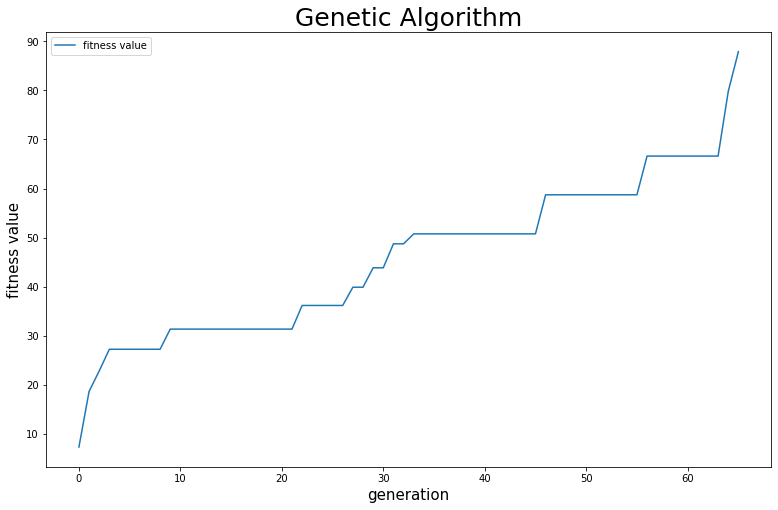

Best generation : 65 
Best fitness value : 87.87537035858075


In [148]:
import matplotlib.pyplot as plt


plt.figure(figsize=(13, 8))
plt.plot(result, label = 'fitness value')
plt.legend()
plt.title('Genetic Algorithm', fontsize=25)
plt.xlabel('generation', fontsize = 15)
plt.ylabel('fitness value', fontsize = 15)
plt.show()

index = result.index(max(result))

print(f'Best generation : {index} \nBest fitness value : {max(result)}')

In [151]:
keyword = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
ind = []
for v in range(len(keyword)):
    if keyword[v] == 1:
        ind.append(v)
print(ind)
len(ind)

[5, 15, 24, 27, 30, 32, 33, 39, 42, 43, 45, 52, 54, 67, 71, 80, 90, 93, 101]


19

## 신규 컨셉 키워드

In [154]:
print(model.wv.index_to_key[5])
print(model.wv.index_to_key[15])
print(model.wv.index_to_key[24])
print(model.wv.index_to_key[27])
print(model.wv.index_to_key[30])
print(model.wv.index_to_key[32])
print(model.wv.index_to_key[33])
print(model.wv.index_to_key[39])
print(model.wv.index_to_key[42])
print(model.wv.index_to_key[43])
print(model.wv.index_to_key[45])
print(model.wv.index_to_key[52])
print(model.wv.index_to_key[54])
print(model.wv.index_to_key[67])
print(model.wv.index_to_key[71])
print(model.wv.index_to_key[80])
print(model.wv.index_to_key[90])
print(model.wv.index_to_key[93])
print(model.wv.index_to_key[101])

케어
정보
이르다
링크
모니터링
사용자
건강
상향
동작
망
보고
신
생체
셀룰러
화
할당
기
통한
매트리스


In [2]:
!jupyter nbconvert --to html final.ipynb

[NbConvertApp] Converting notebook final.ipynb to html
[NbConvertApp] Writing 871278 bytes to final.html
